In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rahmasleam/flowers-dataset")

print("Path to dataset files:", path)

100%|██████████| 219M/219M [00:02<00:00, 97.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/rahmasleam/flowers-dataset/versions/1


In [2]:
import os

In [5]:
path_to_dataset = '/root/.cache/kagglehub/datasets/rahmasleam/flowers-dataset/versions/1'

if not os.path.isdir(path_to_dataset):
    print('not a dir')

In [6]:
os.listdir(path_to_dataset)

['flower_photos']

In [8]:
dataset = os.path.join(path_to_dataset, 'flower_photos')
os.listdir(dataset)

['sunflowers', 'roses', 'dandelion', 'tulips', 'daisy']

In [9]:
import tensorflow as tf
import cv2
from matplotlib import pyplot as plt
import numpy as np

In [10]:
tf.data.Dataset

tensorflow.python.data.ops.dataset_ops.DatasetV2

In [11]:
tf.keras.utils.image_dataset_from_directory

<function keras.src.utils.image_dataset_utils.image_dataset_from_directory(directory, labels='inferred', label_mode='int', class_names=None, color_mode='rgb', batch_size=32, image_size=(256, 256), shuffle=True, seed=None, validation_split=None, subset=None, interpolation='bilinear', follow_links=False, crop_to_aspect_ratio=False, pad_to_aspect_ratio=False, data_format=None, verbose=True)>

In [12]:
data = tf.keras.utils.image_dataset_from_directory(dataset)

Found 3670 files belonging to 5 classes.


In [13]:
data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [14]:
data_iterator = data.as_numpy_iterator()

In [15]:
data_iterator

NumpyIterator(iterator=<tensorflow.python.data.ops.iterator_ops.OwnedIterator object at 0x79eef959fc10>)

In [16]:
batch = data_iterator.next()

In [17]:
print(len(batch))

2


In [19]:
batch[0].shape # Imaginile cu flori

(32, 256, 256, 3)

In [21]:
batch[1] # Etichetele

array([1, 2, 3, 1, 4, 1, 4, 1, 1, 0, 2, 0, 4, 4, 3, 2, 3, 4, 4, 2, 1, 1,
       4, 0, 1, 1, 0, 2, 3, 1, 1, 0], dtype=int32)

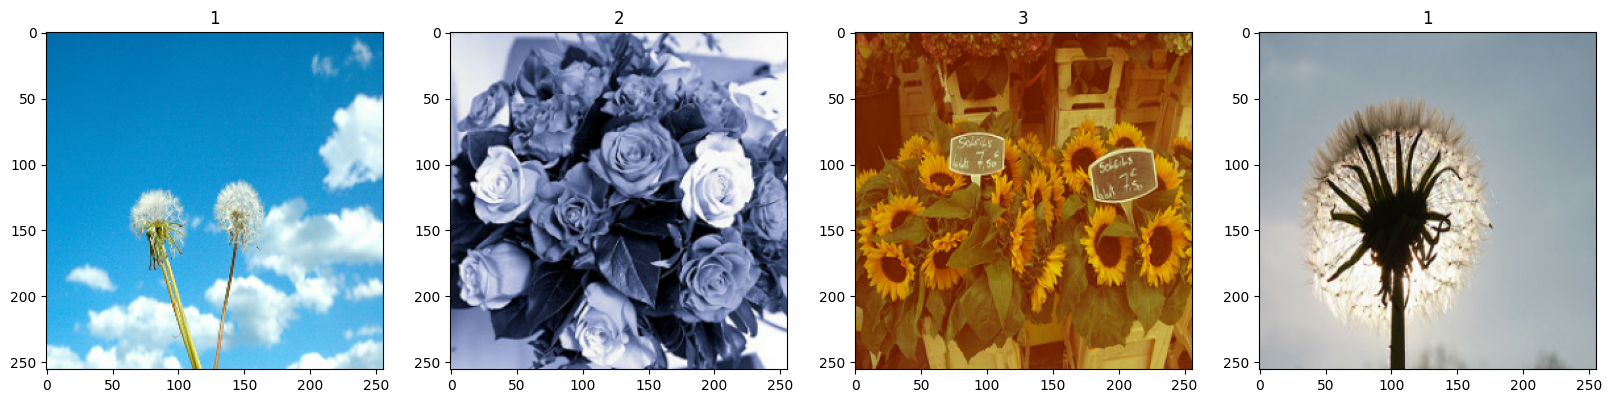

In [22]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [23]:
scaled = batch[0] / 255

In [24]:
scaled.max()

np.float32(1.0)

In [25]:
data = data.map(lambda x,y: (x/255, y))

In [26]:
scaled_iterator = data.as_numpy_iterator()

In [28]:
scaled_iterator.next()[0].max()

np.float32(1.0)

In [29]:
len(data)

115

In [32]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.15) + 2
test_size = int(len(data)*.15) - 1

In [33]:
print(train_size)
print(val_size)
print(test_size)

80
19
16


In [34]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

In [35]:
print(len(train))
print(len(val))
print(len(test))

80
19
16


## Deep Model

In [55]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(256, 256, 3)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2))
])

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2) ))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Conv2D(filters=96, kernel_size=(3,3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2) ))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Conv2D(filters=96, kernel_size=(3,3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2) ))
model.add(tf.keras.layers.Dropout(0.5))

# Flatten

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(units=256, activation='relu'))

# Output

model.add(tf.keras.layers.Dense(units=5, activation='softmax'))

In [56]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 256, 256, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 64, 64, 96)          │          55,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 64, 64, 96)          │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 32, 32, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 32, 32, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 32, 32, 96)          │          83,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 32, 32, 96)          │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 16, 16, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 16, 16, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 24576)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │       6,291,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,451,973 (24.61 MB)

 Trainable params: 6,451,397 (24.61 MB)

 Non-trainable params: 576 (2.25 KB)

In [57]:
for images, labels in train.take(1):
    print("Etichete (labels):")
    print(labels.numpy())

Etichete (labels):
[1 1 4 0 0 4 4 1 3 0 3 4 4 3 3 1 1 1 1 1 4 3 4 4 2 2 4 4 2 4 1 3]


In [58]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# early_stop = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss', patience=5, restore_best_weights=True
# )

# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
#     monitor='val_loss', factor=0.5, patience=3
# )

history = model.fit(
    train,
    validation_data=val,
    batch_size=32,
    epochs=40,
    # callbacks=[early_stop, reduce_lr]
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

print(acc)
print(val_acc)


Epoch 1/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 19s 132ms/step - accuracy: 0.3314 - loss: 9.8898 - val_accuracy: 0.2336 - val_loss: 2.7731
Epoch 2/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 0.5183 - loss: 1.2721 - val_accuracy: 0.2697 - val_loss: 2.4691
Epoch 3/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 0.5978 - loss: 1.0248 - val_accuracy: 0.2730 - val_loss: 2.6272
Epoch 4/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - accuracy: 0.6219 - loss: 0.9465 - val_accuracy: 0.2911 - val_loss: 2.3606
Epoch 5/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 0.6427 - loss: 0.8626 - val_accuracy: 0.3651 - val_loss: 2.3445
Epoch 6/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 0.6823 - loss: 0.8159 - val_accuracy: 0.4095 - val_loss: 2.2705
Epoch 7/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - accuracy: 0.7039 - loss: 0.7702 - val_accuracy: 0.5247 - val_loss: 1.5296
Epoch 8/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 0.7284 - loss: 0.6822 - val_accu

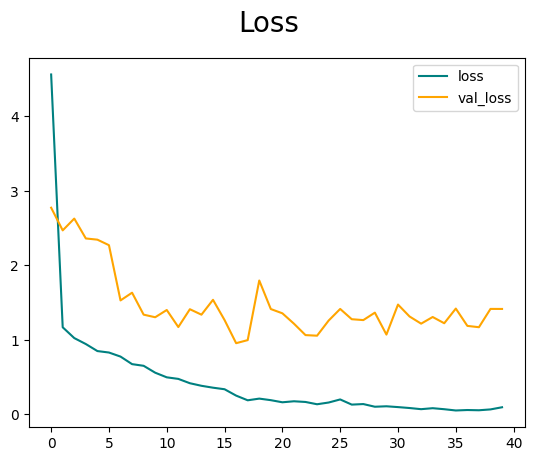

In [65]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper right')
plt.show()



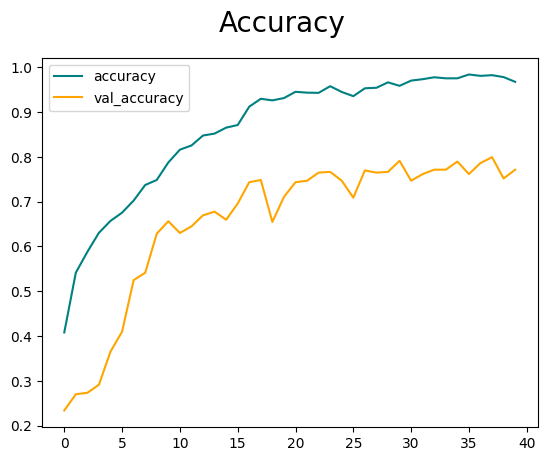

In [66]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

In [67]:
from sklearn.metrics import classification_report
import numpy as np

y_true = []
y_pred = []

for batch in test.as_numpy_iterator():
    X, y = batch
    preds = model.predict(X)
    y_true.extend(y)
    y_pred.extend(np.argmax(preds, axis=1))

print(classification_report(y_true, y_pred))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
              precision    recall  f1-score   support

           0       0.72      0.66      0.69        85
           1       0.61      0.83      0.70       123
           2       0.62      0.68      0.65        77
           3       0.79      0.74      0.76       107
           4       0.74      0.48      0.58       110

    accuracy                           0.68       502
   macro a

In [69]:
save_path = os.getcwd()
if not os.path.isdir(save_path):
    print('not good')
else:
    print(f'path{save_path}')

path/content


In [70]:
path = os.path.join(save_path, '4th_flowers_model.keras')
print(path)
model.save(path)

/content/4th_flowers_model.keras
